## Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
from utils.get_unique_values import get_unique_values
from utils.remove_duplicates import unzip_fn
from utils.show_tile_images import show_tile_images
import zipfile
import json
from utils.visualize_bboxes_on_image import draw_text_on_image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

KeyError: 'bbox_fill_color'

In [ ]:
# !GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/spaces/mckabue/document-similarity-search-using-visual-layout-features --depth=1

# !wget https://huggingface.co/spaces/mckabue/document-similarity-search-using-visual-layout-features/resolve/main/data/processed/RVL-CDIP-invoice/vectors.json.zip -P ./data/processed/RVL-CDIP-invoice/



# import sys
# sys.path.insert(0, './document-similarity-search-using-visual-layout-features')

In [ ]:
# import os
# vectors_chunks = os.listdir('/content/document-similarity-search-using-visual-layout-features/data/processed/RVL-CDIP-invoice/vectors.json.zip.chunks')
# vectors_chunks.sort(key=lambda x: int(x.split('-')[0]))
# vectors_chunks

In [ ]:
vectors_df = pd.read_json('./data/local-data/processed/RVL-CDIP-invoice/vectors.json.zip')
vectors_df

In [ ]:
# https://gemini.google.com/app/8cd4389df12d29e6

# https://chat.openai.com/c/a345a9ec-9238-4089-a6c0-bb4d375148eb

### Correlation

In [ ]:
unique_values = get_unique_values(start=0.17, end=1, count=10*1000)

def get_stats(index: int):
    vectors = vectors_df.loc[index, 'vectors']
    weighted_vectors = vectors_df.loc[index, 'weighted_vectors']
    reduced_vectors = vectors_df.loc[index, 'reduced_vectors']
    reduced_weighted_vectors = vectors_df.loc[index, 'reduced_weighted_vectors']
    non_zero_vectors, non_zero_uniques = unzip_fn([(vector, unique) for vector, unique in zip(vectors, unique_values) if vector > 0])

    non_zero_vectors__uniques  = pearsonr(non_zero_vectors, non_zero_uniques)
    vectors___unique_values = pearsonr(vectors, unique_values)
    vectors___weighted_vectors = pearsonr(vectors, weighted_vectors)
    vectors___reduced_vectors = pearsonr(vectors, reduced_vectors)
    vectors___reduced_weighted_vectors = pearsonr(vectors, reduced_weighted_vectors)
    weighted_vectors___reduced_vectors = pearsonr(weighted_vectors, reduced_vectors)
    weighted_vectors___reduced_weighted_vectors = pearsonr(weighted_vectors, reduced_weighted_vectors)
    reduced_vectors___reduced_weighted_vectors = pearsonr(weighted_vectors, reduced_weighted_vectors)

    return {
        'non_zero_vectors__uniques': non_zero_vectors__uniques,
        'vectors___unique_values': vectors___unique_values,
        'vectors___weighted_vectors': vectors___weighted_vectors,
        'vectors___reduced_vectors': vectors___reduced_vectors,
        'vectors___reduced_weighted_vectors': vectors___reduced_weighted_vectors,
        'weighted_vectors___reduced_vectors': weighted_vectors___reduced_vectors,
        'weighted_vectors___reduced_weighted_vectors': weighted_vectors___reduced_weighted_vectors,
        'reduced_vectors___reduced_weighted_vectors': reduced_vectors___reduced_weighted_vectors,
    }

from matplotlib import pyplot as plt
from scipy.signal import convolve
kernel = np.array([0.25, 0.5, 0.25])  # Example kernel for simple averaging

def smooth_vector(vector):
    # Perform convolution
    smoothed_vector = convolve(vector, kernel, mode='same') / sum(kernel)
    return smoothed_vector

def get_modified_stats(image_1_index: int, image_2_index: int, vector_column: str = 'vectors', plot = False):
    image_1_values = vectors_df.loc[image_1_index, vector_column]
    image_2_values = vectors_df.loc[image_2_index, vector_column]

    image_1_matrix = np.array(image_1_values)
    image_2_matrix = np.array(image_2_values)

    vector_1_zero_indices = image_1_matrix == 0
    vector_2_zero_indices = image_2_matrix == 0

    image_1_matrix[vector_1_zero_indices] = unique_values[vector_1_zero_indices]
    image_2_matrix[vector_2_zero_indices] = unique_values[vector_2_zero_indices]

    _old_pearsonr = pearsonr(image_1_values, image_2_values)
    [[_old_cosine_similarity]] = cosine_similarity([image_1_values], [image_2_values])
    _pearsonr = pearsonr(image_1_matrix, image_2_matrix)
    [[_cosine_similarity]] = cosine_similarity([image_1_matrix], [image_2_matrix])

    image_1_matrix_smooth = smooth_vector(image_1_matrix)
    image_2_matrix_smooth = smooth_vector(image_2_matrix)
    _pearsonr_smooth = pearsonr(image_1_matrix_smooth, image_2_matrix)
    [[_cosine_similarity_smooth]] = cosine_similarity([image_1_matrix_smooth], [image_2_matrix])

    permuted_indices = np.random.permutation(len(image_1_matrix))
    _pearsonr_random = pearsonr(image_1_matrix[permuted_indices], image_2_matrix[permuted_indices])
    [[_cosine_similarity_random]] = cosine_similarity([image_1_matrix[permuted_indices]], [image_2_matrix[permuted_indices]])

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(image_1_values, label='image_1_values', color = 'red')
        plt.plot(image_1_matrix_smooth, label='image_1_matrix_smooth', color = 'blue')
        # plt.plot(image_1_matrix, label='image_1_matrix', linestyle='--', color = 'blue')
        # plt.plot(image_1_matrix_smooth, label='image_1_matrix_smooth', linestyle='--', color = "green")
        plt.show()

    return {
        'old_pearsonr'          : f'{round(_old_pearsonr.statistic, 4)} - {_old_pearsonr.pvalue}',
        'old_cosine_similarity' : round(_old_cosine_similarity, 4),
        'pearsonr'              : f'{round(_pearsonr.statistic, 4)} - {_pearsonr.pvalue}',
        'cosine_similarity'     : round(_cosine_similarity, 4),
        'pearsonr_smooth'              : f'{round(_pearsonr_smooth.statistic, 4)} - {_pearsonr_smooth.pvalue}',
        'cosine_similarity_smooth'     : round(_cosine_similarity_smooth, 4),
        'pearsonr_random'              : f'{round(_pearsonr_random.statistic, 4)} - {_pearsonr_random.pvalue}',
        'cosine_similarity_random'     : round(_cosine_similarity_random, 4),
    }


In [ ]:
get_stats(0)

In [ ]:
with  zipfile.ZipFile('./data/local-data/processed/RVL-CDIP-invoice/cosine_similarity_scores/vectors_column.json.zip', "r") as zip_ref:
    similarity_vectors_json = json.loads(zip_ref.read(zip_ref.filelist[0].filename))

In [ ]:
top_matches = [
    similarity for similarity in 
    similarity_vectors_json 
    if similarity['cosine_similarity_score'] > 0.8 and 
    similarity['document_image_1'] != similarity['document_image_2']]
top_matches.sort(key=lambda similarity: similarity['cosine_similarity_score'], reverse=True)

In [ ]:
def get_image(filename: str):
    return Image.open(f'./data/local-data/raw/RVL-CDIP-invoice/{filename}')

def print_matches(matches, two_column_count, *, start = 0):
    images_range = range(start, start + two_column_count)
    images = np.array(
        [
            [
                get_image(matches[i]['document_image_1']), 
                get_image(matches[i]['document_image_2']),
                draw_text_on_image(
                    Image.new("RGB", (800, 1200), 'white'),
                    [100, 100],
                    json.dumps(
                        get_modified_stats(
                            int(matches[i]['document_image_1'].split('.')[0]), 
                            int(matches[i]['document_image_2'].split('.')[0]), 
                            'vectors'), 
                        indent=4),
                    label_text_size=40,
                    label_rectangle_color='white',
                ),
            ]
            for i
            in images_range
        ],
        dtype="object").flatten().tolist()
    titles = np.array(
        [
            [
                f"{matches[i]['document_image_1']}, Similarity - {round(matches[i]['cosine_similarity_score'], 4)}", 
                matches[i]['document_image_2'],
                'More Statistics',
            ]
            for i
            in images_range
        ]).flatten().tolist()
    width_parts = 3
    return show_tile_images(
        images,
        titles = titles,
        width_parts = width_parts,
        figsize = (10.2 * width_parts, 12 * (len(images) / width_parts)),
        space = 2,
        pad = True,
        figcolor = '#d3eddd',
        title_color = 'black',
        title_background_color = 'white',
        title_font_size = 30)

print_matches(top_matches, 2, start=0)

In [ ]:
almost_similar = [similarity for similarity in 
    similarity_vectors_json 
    if similarity['cosine_similarity_score'] > 0.9 and similarity['cosine_similarity_score'] < 1.0]
almost_similar.sort(key=lambda similarity: similarity['cosine_similarity_score'], reverse=True)

In [ ]:
print_matches(almost_similar, 5, start=0)

In [ ]:
from main import app

model_path = '../detectron2-layout-parser/model_final.pth'
config_path = '../detectron2-layout-parser/config.yaml'
app(model_path=model_path, config_path=config_path, debug=True)

In [95]:
int(12.9)

12

In [124]:
from PIL import Image
from PIL import ImageDraw
back = Image.open(
    '/Users/charleskabue/document-similarity-search/detectron2-layout-parser/example.3.jpg')
x0, y0, x1, y1 = [100, 100, 500, 500]
width, height = x1 - x0, y1 - y0
outline_width = 10
poly = Image.new('RGBA', (1000, 1000))
pdraw = ImageDraw.Draw(poly)
pdraw.rectangle([x0, y0, x1-outline_width, y1-outline_width],
                fill=(256, 0, 0, 123), outline=(0, 0, 256, 123), width=outline_width)
back.paste(
    poly,
    box=[x0, y0, x1, y1],
    mask=poly)
back

ValueError: images do not match

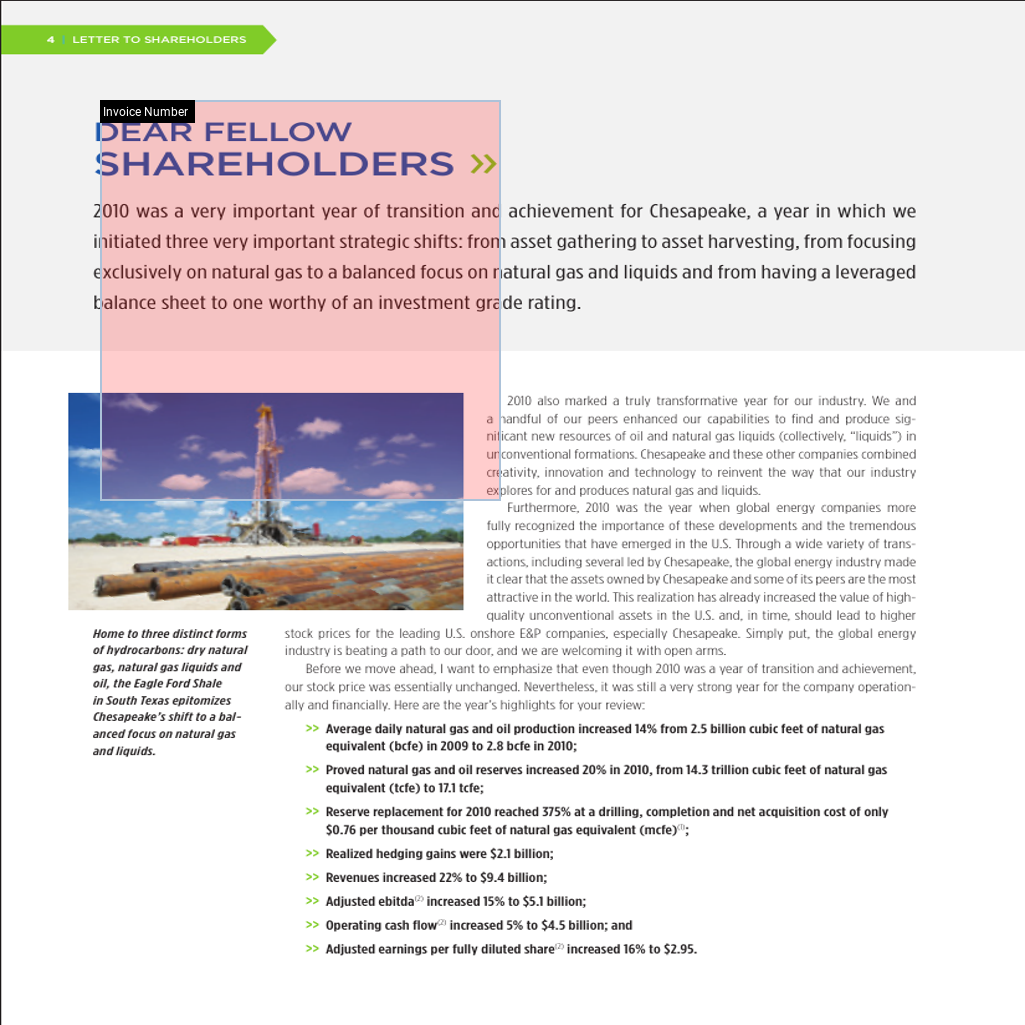

In [156]:
from utils.visualize_bboxes_on_image import visualize_bboxes_on_image

image = Image.open('/Users/charleskabue/document-similarity-search/detectron2-layout-parser/example.3.jpg')
visualize_bboxes_on_image_kwargs = {
    'label_text_color': 'white',
    'label_fill_color': 'black',
    'label_text_size': 12,
    'label_text_padding': 3,
    'label_rectangle_left_margin': 0,
    'label_rectangle_top_margin': 0,
    'bbox_outline_color': '#acc2d9', # alpha runs from 0 to 127
    # 'bbox_fill_color': (0, 0, 256, 123), # alpha runs from 0 to 127
}
visualize_bboxes_on_image(
    image,
    [[100, 100, 500, 500]],
    ['Invoice Number'],
    **visualize_bboxes_on_image_kwargs
)

In [151]:
import numpy as np

[(0,0,0,0)] * 3

[(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)]